# 0. Preprocessing

## Read Dataset

In [1]:
import pandas as pd

train_data = pd.read_csv('pp5i_train.gr.csv', index_col=0)
test_data = pd.read_csv('pp5i_test.gr.csv', index_col=0)
train_class = pd.read_csv('pp5i_train_class.txt')
train_class['Class'].value_counts()

MED    39
EPD    10
MGL     7
RHB     7
JPA     6
Name: Class, dtype: int64

# 1. Data Cleaning
Threshold both train and test data to a minimum value of 20, maximum of 16,000.

In [2]:
import numpy as np

train_data[(train_data < 20) | (train_data > 16000)] = np.nan
test_data[(test_data < 20) | (test_data > 16000)] = np.nan

train_data_clean = train_data[(~train_data.isnull().any(1)) & (~test_data.isnull().any(1))]
test_data_clean = test_data[(~train_data.isnull().any(1)) & (~test_data.isnull().any(1))]

# 2. Selecting top genes by class
Remove from train data genes with fold differences across samples less than 2. Fold difference is defined as a ratio between maximum and minimum values
(Max/Min) for a given data set.

In [3]:
train_data_fold = train_data_clean[train_data_clean.apply(lambda x: x.max()/x.min() > 2, axis=1)]

For each class, generate subsets with top 2,4,6,8,10,12,15,20,25, and 30 top genes with the highest absolute [T-value](https://www.biologyforlife.com/ttest.html). The objective of this step is to find for each class the set of best genes to discriminate it from the other classes.

In [4]:
from scipy import stats

classes = np.unique(train_class.values)

t_values = pd.DataFrame(index=train_data_fold.index.tolist())
for label in classes:
  for gene in train_data_fold.index.tolist():
    cur_samples = train_data_fold.loc[gene][np.ravel((train_class==label).values.tolist())]
    rest_samples = train_data_fold.loc[gene][np.ravel((train_class!=label).values.tolist())]
    t_values.loc[gene, label] = abs(stats.ttest_ind(cur_samples, rest_samples,
                                                    equal_var=False, nan_policy='raise')[0])

For N=2,4,6,8,10,12,15,20,25,30 combine top genes for each class into one file (removing duplicates, if any) and call the resulting file `pp5i_train.topN.gr.csv`.

Add the class as the last column, remove sample no, transpose each file to
"genes-in-columns" format.

In [ ]:
N = [2,4,6,8,10,12,15,20,25,30]

for n in N:
  top_genes = set()
  for label in classes:
    top_genes.update(t_values.sort_values(label, ascending=False).head(n).index.tolist())
  pd.concat([train_data_fold.loc[list(top_genes), :].T.reset_index(drop=True), train_class],
            axis=1).to_csv('pp5i_train.top'+str(n)+'.gr.csv', index=False)

# 3. Find the best classifier/best gene set combination
Use the following classifiers:
* Naïve Bayes
* Decision tree (J48 algorithm)
* K-NN (IBk algorithm)
* Neural network
* One more classifier of your choice.

For each classifier, using default settings, measure classifier accuracy on the training set using previously generated files with top N=2, 4, 6, 8, 10, 12, 15, 20, 25, 30 genes. For K-NN, test accuracy with K=2, 3 and 4.

Select the model and the gene set with the lowest cross-validation error. Crossvalidation is your main tool to measure classification accuracy. If you are using Python, search for [resources](https://scikit-learn.org/stable/modules/cross_validation.html) that show how it can be calculated.

Once you found the gene set with the lowest cross-validation error, you can vary
1-2 additional relevant parameters for each classifier to see if the accuracy will
improve.

In [5]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit(classes)

for n in N:
    globals()['x_train%s' % n] = pd.read_csv('pp5i_train.top'+str(n)+'.gr.csv').drop(labels='Class', axis=1).values.tolist()
    globals()['y_train%s' % n] = LE.transform(np.ravel(pd.read_csv('pp5i_train.top'+str(n)+'.gr.csv', usecols=['Class']).values.tolist()))

## Naïve Bayes

N=2 accuracy: 0.94 (+/- 0.11)
N=4 accuracy: 0.92 (+/- 0.14)
N=6 accuracy: 0.95 (+/- 0.10)
N=8 accuracy: 0.95 (+/- 0.10)
N=10 accuracy: 0.95 (+/- 0.10)
N=12 accuracy: 0.93 (+/- 0.08)
N=15 accuracy: 0.92 (+/- 0.11)
N=20 accuracy: 0.93 (+/- 0.08)
N=25 accuracy: 0.95 (+/- 0.10)
N=30 accuracy: 0.95 (+/- 0.10)


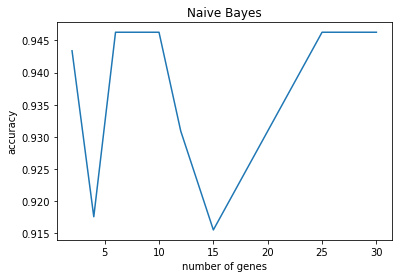

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

GNBclf = GaussianNB()

def search_gene(clf):
    best_score = 0
    accuracy = []
    for n in N:
        scores = cross_val_score(clf, globals()['x_train%s'%n], globals()['y_train%s'%n], cv=5, n_jobs=-1)
        score = scores.mean()
        accuracy.append(score)
        print("N=%d accuracy: %0.2f (+/- %0.2f)" % (n, score, scores.std() * 2))
        best_n = n if score > best_score else best_n
        best_score = score if score > best_score else best_score
    return best_n, accuracy

best_n, scores = search_gene(GNBclf)

def draw(scores, name):
    plt.plot(N, scores)
    plt.xlabel('number of genes')
    plt.ylabel('accuracy')
    plt.title(name)
    plt.show()
    
draw(scores, 'Naive Bayes')

In [7]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB

MNBclf = MultinomialNB()
CNBclf = ComplementNB()
BNBclf = BernoulliNB()

for c in ['G', 'M', 'C', 'B']:
    scores = cross_val_score(globals()[c+'NBclf'], globals()['x_train%s' % best_n], globals()['y_train%s' % best_n], cv=5, n_jobs=-1)
    print("N=%d %sNBclf accuracy: %0.2f (+/- %0.2f)" % (best_n, c, scores.mean(), scores.std() * 2))

N=6 GNBclf accuracy: 0.95 (+/- 0.10)
N=6 MNBclf accuracy: 0.96 (+/- 0.11)
N=6 CNBclf accuracy: 0.86 (+/- 0.12)
N=6 BNBclf accuracy: 0.57 (+/- 0.09)


## Decision tree

N=2 accuracy: 0.78 (+/- 0.31)
N=4 accuracy: 0.78 (+/- 0.20)
N=6 accuracy: 0.80 (+/- 0.29)
N=8 accuracy: 0.84 (+/- 0.31)
N=10 accuracy: 0.80 (+/- 0.29)
N=12 accuracy: 0.79 (+/- 0.21)
N=15 accuracy: 0.72 (+/- 0.35)
N=20 accuracy: 0.82 (+/- 0.27)
N=25 accuracy: 0.69 (+/- 0.37)
N=30 accuracy: 0.73 (+/- 0.29)


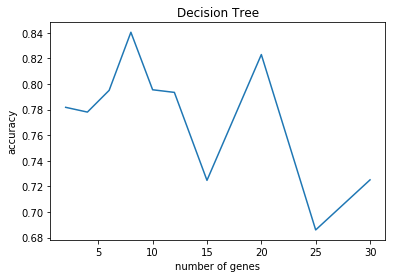

In [8]:
from sklearn.tree import DecisionTreeClassifier

DTclf = DecisionTreeClassifier()

best_n, scores = search_gene(DTclf)

draw(scores, 'Decision Tree')

In [9]:
from sklearn.model_selection import GridSearchCV


params = {
    'max_depth': [30, 60, 90, None],
    'class_weight': ['balanced', None]
}

def print_results(results):
    print('Best Params: {}\n'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 2), round(std * 2, 2), params))

def search_param(clf, params, n):
    cv = GridSearchCV(clf, params, cv=5, n_jobs=-1, iid=False)
    cv.fit(globals()['x_train%s' % n], globals()['y_train%s' % n])

    print('N=%s:' % n)    
    print_results(cv)
  
search_param(DTclf, params, best_n)

N=8:
Best Params: {'class_weight': None, 'max_depth': 30}

0.81 (+/-0.19) for {'class_weight': 'balanced', 'max_depth': 30}
0.82 (+/-0.27) for {'class_weight': 'balanced', 'max_depth': 60}
0.81 (+/-0.19) for {'class_weight': 'balanced', 'max_depth': 90}
0.86 (+/-0.18) for {'class_weight': 'balanced', 'max_depth': None}
0.89 (+/-0.14) for {'class_weight': None, 'max_depth': 30}
0.78 (+/-0.23) for {'class_weight': None, 'max_depth': 60}
0.76 (+/-0.34) for {'class_weight': None, 'max_depth': 90}
0.77 (+/-0.26) for {'class_weight': None, 'max_depth': None}


## K-NN

N=2:
Best Params: {'n_neighbors': 4}

0.93 (+/-0.15) for {'n_neighbors': 2}
0.95 (+/-0.1) for {'n_neighbors': 3}
0.96 (+/-0.11) for {'n_neighbors': 4}
N=4:
Best Params: {'n_neighbors': 3}

0.9 (+/-0.07) for {'n_neighbors': 2}
0.93 (+/-0.02) for {'n_neighbors': 3}
0.93 (+/-0.02) for {'n_neighbors': 4}
N=6:
Best Params: {'n_neighbors': 4}

0.91 (+/-0.07) for {'n_neighbors': 2}
0.93 (+/-0.02) for {'n_neighbors': 3}
0.94 (+/-0.06) for {'n_neighbors': 4}
N=8:
Best Params: {'n_neighbors': 3}

0.89 (+/-0.14) for {'n_neighbors': 2}
0.93 (+/-0.08) for {'n_neighbors': 3}
0.92 (+/-0.09) for {'n_neighbors': 4}
N=10:
Best Params: {'n_neighbors': 3}

0.9 (+/-0.13) for {'n_neighbors': 2}
0.93 (+/-0.08) for {'n_neighbors': 3}
0.9 (+/-0.05) for {'n_neighbors': 4}
N=12:
Best Params: {'n_neighbors': 2}

0.92 (+/-0.09) for {'n_neighbors': 2}
0.9 (+/-0.08) for {'n_neighbors': 3}
0.9 (+/-0.05) for {'n_neighbors': 4}
N=15:
Best Params: {'n_neighbors': 3}

0.86 (+/-0.16) for {'n_neighbors': 2}
0.9 (+/-0.08) f

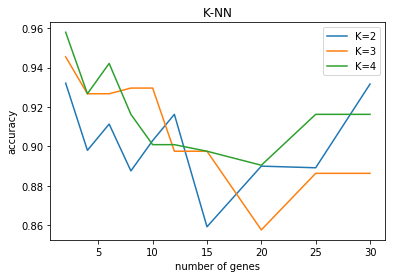

Best Params: N=2, K=4


In [14]:
from sklearn.neighbors import KNeighborsClassifier

KNNclf = KNeighborsClassifier(n_jobs=-1)

params = {
    'n_neighbors': [2, 3, 4]
}

best_score = 0
accuracy = []
for n in N:
    cv = GridSearchCV(KNNclf, params, cv=5, n_jobs=-1, iid=False)
    cv.fit(globals()['x_train%s'%n], globals()['y_train%s'%n])
    score = max(cv.cv_results_['mean_test_score'])
    accuracy.append(list(cv.cv_results_['mean_test_score']))
    best_n = n if score > best_score else best_n
    best_K = cv.best_params_['n_neighbors'] if score > best_score else best_K
    best_score = score if score > best_score else best_score
    print('N=%s:'%n)
    print_results(cv)

accuracy = np.array(accuracy)
plt.plot(N, accuracy[:, 0], label='K=2')
plt.plot(N, accuracy[:, 1], label='K=3')
plt.plot(N, accuracy[:, 2], label='K=4')
plt.xlabel('number of genes')
plt.ylabel('accuracy')
plt.title('K-NN')
plt.legend()
plt.show()

print('Best Params: N=%d, K=%d' % (best_n, best_K))

In [15]:
KNN4clf = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)

params = {
    'n_neighbors': [2, 3, 4],
    'weights' : ['uniform', 'distance']
}

search_param(KNN4clf, params, best_n)

N=2:
Best Params: {'n_neighbors': 4, 'weights': 'uniform'}

0.93 (+/-0.15) for {'n_neighbors': 2, 'weights': 'uniform'}
0.93 (+/-0.13) for {'n_neighbors': 2, 'weights': 'distance'}
0.95 (+/-0.1) for {'n_neighbors': 3, 'weights': 'uniform'}
0.95 (+/-0.1) for {'n_neighbors': 3, 'weights': 'distance'}
0.96 (+/-0.11) for {'n_neighbors': 4, 'weights': 'uniform'}
0.95 (+/-0.1) for {'n_neighbors': 4, 'weights': 'distance'}


## Neural network

N=2 accuracy: 0.84 (+/- 0.27)
N=4 accuracy: 0.72 (+/- 0.43)
N=6 accuracy: 0.88 (+/- 0.18)
N=8 accuracy: 0.90 (+/- 0.13)
N=10 accuracy: 0.84 (+/- 0.17)
N=12 accuracy: 0.81 (+/- 0.27)
N=15 accuracy: 0.86 (+/- 0.19)
N=20 accuracy: 0.81 (+/- 0.23)
N=25 accuracy: 0.94 (+/- 0.06)
N=30 accuracy: 0.83 (+/- 0.11)


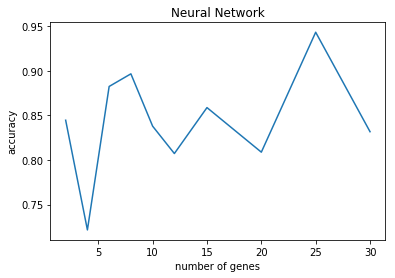

In [41]:
from sklearn.neural_network import MLPClassifier

NNclf = MLPClassifier()
best_n, scores = search_gene(NNclf)

draw(scores, 'Neural Network')

In [20]:
params = {
    'hidden_layer_sizes' : [(100,), (200,), (400,)],
    'activation' : ['identity', 'logistic', 'tanh', 'relu']
}

search_param(NNclf, params, best_n)

N=8:
Best Params: {'activation': 'logistic', 'hidden_layer_sizes': (200,)}

0.83 (+/-0.21) for {'activation': 'identity', 'hidden_layer_sizes': (100,)}
0.89 (+/-0.15) for {'activation': 'identity', 'hidden_layer_sizes': (200,)}
0.86 (+/-0.12) for {'activation': 'identity', 'hidden_layer_sizes': (400,)}
0.94 (+/-0.11) for {'activation': 'logistic', 'hidden_layer_sizes': (100,)}
0.97 (+/-0.06) for {'activation': 'logistic', 'hidden_layer_sizes': (200,)}
0.97 (+/-0.06) for {'activation': 'logistic', 'hidden_layer_sizes': (400,)}
0.91 (+/-0.13) for {'activation': 'tanh', 'hidden_layer_sizes': (100,)}
0.95 (+/-0.1) for {'activation': 'tanh', 'hidden_layer_sizes': (200,)}
0.97 (+/-0.07) for {'activation': 'tanh', 'hidden_layer_sizes': (400,)}
0.87 (+/-0.17) for {'activation': 'relu', 'hidden_layer_sizes': (100,)}
0.88 (+/-0.07) for {'activation': 'relu', 'hidden_layer_sizes': (200,)}
0.89 (+/-0.09) for {'activation': 'relu', 'hidden_layer_sizes': (400,)}


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Random forest

N=2 accuracy: 0.86 (+/- 0.12)
N=4 accuracy: 0.93 (+/- 0.14)
N=6 accuracy: 0.89 (+/- 0.17)
N=8 accuracy: 0.94 (+/- 0.16)
N=10 accuracy: 0.91 (+/- 0.13)
N=12 accuracy: 0.87 (+/- 0.26)
N=15 accuracy: 0.92 (+/- 0.14)
N=20 accuracy: 0.89 (+/- 0.10)
N=25 accuracy: 0.90 (+/- 0.11)
N=30 accuracy: 0.87 (+/- 0.09)


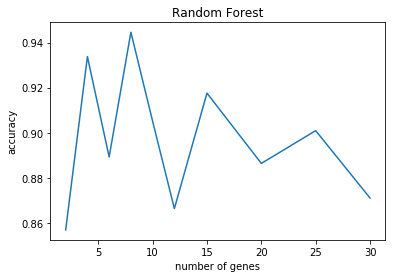

In [10]:
from sklearn.ensemble import RandomForestClassifier

RFclf = RandomForestClassifier(n_jobs=-1)
best_n, scores = search_gene(RFclf)

draw(scores, 'Random Forest')

In [11]:
params = {
    'n_estimators': [100, 150, 300],
    'max_depth' : [30, 60, 90, None],
    'class_weight' : ['balanced']
}

search_param(RFclf, params, best_n)

N=8:
Best Params: {'class_weight': 'balanced', 'max_depth': 90, 'n_estimators': 150}

0.95 (+/-0.1) for {'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 100}
0.95 (+/-0.15) for {'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 150}
0.97 (+/-0.07) for {'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 300}
0.96 (+/-0.1) for {'class_weight': 'balanced', 'max_depth': 60, 'n_estimators': 100}
0.97 (+/-0.07) for {'class_weight': 'balanced', 'max_depth': 60, 'n_estimators': 150}
0.97 (+/-0.07) for {'class_weight': 'balanced', 'max_depth': 60, 'n_estimators': 300}
0.95 (+/-0.1) for {'class_weight': 'balanced', 'max_depth': 90, 'n_estimators': 100}
0.98 (+/-0.06) for {'class_weight': 'balanced', 'max_depth': 90, 'n_estimators': 150}
0.97 (+/-0.07) for {'class_weight': 'balanced', 'max_depth': 90, 'n_estimators': 300}
0.92 (+/-0.18) for {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 100}
0.95 (+/-0.15) for {'class_weight': 'balanced', 'max_de

Use the gene names from best train gene set and extract the data corresponding
to these genes from the test set.

Convert test set to genes-in-columns format to prepare it for classification.

In [12]:
best_n = 8
y_test = test_data.loc[pd.read_csv('pp5i_train.top'+str(best_n)+'.gr.csv').drop(labels='Class',
                                                                           axis=1).columns.tolist(), :].T.reset_index(drop=True)

# 4. Generate predictions for the test set
You should now have the best train file, call it pp5i_train.bestN.csv, (with 69 samples and bestN number of genes for whatever best N you found) and a corresponding test file, call it pp5i_test.bestN.csv, with the same genes and 23 test samples.

In [13]:
pd.read_csv('pp5i_train.top'+str(best_n)+'.gr.csv').to_csv('pp5i_train.best'+str(best_n)+'.csv', index=False)
y_test.to_csv('pp5i_test.best'+str(best_n)+'.csv', index=False)

Use the best train file and the matching test file and generate predictions for the test file class.

In [14]:
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

x_train = pd.read_csv('pp5i_train.best'+str(best_n)+'.csv').drop(labels='Class', axis=1).values.tolist()
y_train = LE.transform(np.ravel(pd.read_csv('pp5i_train.best'+str(best_n)+'.csv', usecols=['Class']).values.tolist()))
sample_weight = class_weight.compute_sample_weight('balanced', y_train)

clf = RandomForestClassifier(n_estimators=150, max_depth=90, n_jobs=-1, class_weight='balanced')
clf.fit(x_train, y_train, sample_weight=sample_weight)
np.savetxt('pp5i_test_class.txt', LE.inverse_transform(clf.predict(y_test)), fmt='%s')
print(classification_report(y_train, clf.predict(x_train), target_names=classes))

              precision    recall  f1-score   support

         EPD       1.00      1.00      1.00        10
         JPA       1.00      1.00      1.00         6
         MED       1.00      1.00      1.00        39
         MGL       1.00      1.00      1.00         7
         RHB       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

